<a href="https://colab.research.google.com/github/bspanswick/STLF/blob/main/STLF_VAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [166]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

import math 
import numpy as np 
import pandas as pd 
from datetime import date, timedelta, datetime 
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt  
import matplotlib.dates as mdates 
from sklearn.metrics import mean_absolute_error, mean_squared_error 
from keras.models import Sequential 
from keras.layers import LSTM, Dense, Dropout 
from keras.callbacks import EarlyStopping 
from sklearn.preprocessing import RobustScaler, MinMaxScaler 
import seaborn as sns
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot
from pandas import DataFrame
from statsmodels.tsa.api import VAR


In [48]:
weather = pd.read_csv('/content/drive/MyDrive/AMTLF/weather.csv')
pjm = pd.read_csv('/content/drive/MyDrive/AMTLF/pjm.csv') 

In [49]:
weather.head()

,DATA_DATE_and_HOUR,TEMPERATURE,WIND_SPEED_MPH,WIND_GUST_MPH,RELATIVE_HUMIDITY,CLOUD_COVER,PRECIPITATION
0,01/Jan/2015 01,17.0,12.0,12.0,49.0,19.0,0.0
1,01/Jan/2015 02,17.0,12.0,12.0,49.0,10.0,0.0
2,01/Jan/2015 03,17.0,14.0,14.0,51.0,0.0,0.0
3,01/Jan/2015 04,16.0,12.0,12.0,54.0,0.0,0.0
4,01/Jan/2015 05,15.0,7.0,7.0,56.0,0.0,0.0


In [50]:
pjm.head()

,datetime_beginning_utc,datetime_beginning_ept,nerc_region,mkt_region,zone,load_area,mw,is_verified
0,2017-01-01T20:00:00.000Z,2017-01-01T15:00:00.000Z,RFC,MIDATL,PL,PLCO,4039.059,True
1,2017-01-01T22:00:00.000Z,2017-01-01T17:00:00.000Z,RFC,MIDATL,PL,PLCO,4658.056,True
2,2017-01-02T08:00:00.000Z,2017-01-02T03:00:00.000Z,RFC,MIDATL,PL,PLCO,3854.594,True
3,2017-01-02T11:00:00.000Z,2017-01-02T06:00:00.000Z,RFC,MIDATL,PL,PLCO,4269.468,True
4,2017-01-02T13:00:00.000Z,2017-01-02T08:00:00.000Z,RFC,MIDATL,PL,PLCO,4746.482,True


In [51]:
#set datetimes and get min/max/mean for days

weather = weather.rename(columns={ weather.columns[0]: "datetime" })
weather.datetime = pd.to_datetime(weather['datetime'])
weather['time'],weather['date']= weather['datetime'].apply(lambda x:x.time()), weather['datetime'].apply(lambda x:x.date())
weather1 = weather.groupby('date').agg({'TEMPERATURE': ['mean', 'min', 'max'],
                                       'RELATIVE_HUMIDITY': ['mean'],
                                       'WIND_GUST_MPH': ['mean'],
                                       'CLOUD_COVER': ['mean'],
                                       'PRECIPITATION': ['mean']})
#convert back to usable dataframe
weather1.columns = ['_'.join(col) for col in weather1.columns]
weather1 = weather1.reset_index()
weather1.date = pd.to_datetime(weather1['date'])

In [52]:
#get day of week and check for federal holiday

weather1['weekday'] =weather1['date'].dt.dayofweek
weather1['month'] = weather1['date'].dt.month
cal = calendar()
holidays = cal.holidays(start=weather1.date.min(), end=weather1.date.max())
weather1['holiday'] = weather1['date'].isin(holidays).astype(int)

In [53]:
pjm = pjm.rename(columns={ pjm.columns[1]: "datetime" })
pjm.datetime = pd.to_datetime(pjm['datetime'])
pjm['time'],pjm['date']= pjm['datetime'].apply(lambda x:x.time()), pjm['datetime'].apply(lambda x:x.date())
pjm1 = pjm.groupby('date').agg({'mw': ['max']})
pjm1.columns = ['_'.join(col) for col in pjm1.columns]
pjm1 = pjm1.reset_index()
pjm1.date = pd.to_datetime(pjm1['date'])

In [54]:
weather1.head()

,date,TEMPERATURE_mean,TEMPERATURE_min,TEMPERATURE_max,RELATIVE_HUMIDITY_mean,WIND_GUST_MPH_mean,CLOUD_COVER_mean,PRECIPITATION_mean,weekday,month,holiday
0,2015-01-01,28.878261,14.0,42.0,54.343478,11.800000,5.686957,0.0000,3,1,1
1,2015-01-02,31.508333,19.0,43.0,61.887500,6.787500,32.333333,0.0000,4,1,0
2,2015-01-03,29.845833,18.0,40.0,80.008333,5.262500,77.025000,47.8500,5,1,0
3,2015-01-04,40.725000,34.0,58.0,78.987500,9.333333,94.629167,30.1125,6,1,0
4,2015-01-05,29.687500,10.0,45.0,56.333333,27.516667,46.662500,0.4125,0,1,0


In [55]:
#checking some of the data for missing dates, and date ranges

print(pjm1.date.max())
print(weather1.date.min())
print(pd.date_range(start = weather1.date.min(), end = weather1.date.max() ).difference(weather1.date))
print(pd.date_range(start = weather1.date.min(), end = weather1.date.max() ).difference(pjm1.date))


2019-12-31 00:00:00
2015-01-01 00:00:00
DatetimeIndex([], dtype='datetime64[ns]', freq=None)
DatetimeIndex([], dtype='datetime64[ns]', freq=None)


In [150]:
df = pd.merge(weather1, pjm1, on='date', how='outer')
df = df.dropna()
#df['date'] = pd.to_datetime(df['date'])
#df = df.set_index('date')
#df = df.reset_index()
df.head()

,date,TEMPERATURE_mean,TEMPERATURE_min,TEMPERATURE_max,RELATIVE_HUMIDITY_mean,WIND_GUST_MPH_mean,CLOUD_COVER_mean,PRECIPITATION_mean,weekday,month,holiday,mw_max
0,2015-01-01,28.878261,14.0,42.0,54.343478,11.800000,5.686957,0.0000,3.0,1.0,1.0,5214.883
1,2015-01-02,31.508333,19.0,43.0,61.887500,6.787500,32.333333,0.0000,4.0,1.0,0.0,5464.446
2,2015-01-03,29.845833,18.0,40.0,80.008333,5.262500,77.025000,47.8500,5.0,1.0,0.0,5572.899
3,2015-01-04,40.725000,34.0,58.0,78.987500,9.333333,94.629167,30.1125,6.0,1.0,0.0,4985.939
4,2015-01-05,29.687500,10.0,45.0,56.333333,27.516667,46.662500,0.4125,0.0,1.0,0.0,6336.146


In [132]:
FEATURES = df.columns
FEATURES_prophet = ['ds', 'TEMPERATURE_mean', 'TEMPERATURE_min', 'TEMPERATURE_max',
       'RELATIVE_HUMIDITY_mean', 'WIND_GUST_MPH_mean', 'CLOUD_COVER_mean',
       'PRECIPITATION_mean', 'weekday', 'month', 'holiday', 'y']

In [151]:
# ## Keep the masterdf intact, select current data until March as current data

alldf = df.copy()
alldf.index = pd.DatetimeIndex(alldf.date)
alldf = alldf.sort_index()

### fill any missing values on previous date using backfill
alldf = alldf.fillna(method='bfill')

alldf.index = pd.DatetimeIndex(alldf.date)
alldf = alldf[alldf.index < '2020-04-01']
alldf = alldf.reset_index(drop=True)

## we rename date as 'ds' and Net Sales as 'y'
## Prophet makes it compulsory to rename these columns as such
alldf = alldf.rename(columns={'date':'ds',
                     'mw_max':'y'
                     })
# alldf['ds'] = pd.to_datetime(alldf['ds'])

tsdf = alldf.copy()
tsdf['ds'] = pd.to_datetime(tsdf['ds'])
tsdf.index = pd.DatetimeIndex(tsdf.ds)
tsdf = tsdf.drop('ds', 1)

In [152]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test' 


df = pd.DataFrame(np.zeros((len(tsdf.columns), len(tsdf.columns))), columns=tsdf.columns, index=tsdf.columns)
for c in df.columns:
    for r in df.index:
        test_result = grangercausalitytests(tsdf[[r, c]], maxlag=maxlag, verbose=False)
        p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
        min_p_value = np.min(p_values)
        df.loc[r, c] = min_p_value
df.columns = [var + '_x' for var in tsdf.columns]
df.index = [var + '_y' for var in tsdf.columns]

grangerdf = df

grangerdf

,TEMPERATURE_mean_x,TEMPERATURE_min_x,TEMPERATURE_max_x,RELATIVE_HUMIDITY_mean_x,WIND_GUST_MPH_mean_x,CLOUD_COVER_mean_x,PRECIPITATION_mean_x,weekday_x,month_x,holiday_x,y_x
TEMPERATURE_mean_y,1.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0542,0.0000,0.0076,0.0069
TEMPERATURE_min_y,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0078,0.0016,0.0082,0.0018
TEMPERATURE_max_y,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0003,0.1113,0.0002,0.0621,0.3666
RELATIVE_HUMIDITY_mean_y,0.0001,0.0002,0.0001,1.0000,0.0000,0.0000,0.0000,0.2672,0.0000,0.4288,0.1578
WIND_GUST_MPH_mean_y,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.1626,0.0000,0.0258,0.1324
CLOUD_COVER_mean_y,0.0000,0.0000,0.0000,0.0005,0.0000,1.0000,0.0021,0.8060,0.1975,0.5534,0.1669
PRECIPITATION_mean_y,0.0228,0.0074,0.0605,0.0120,0.0001,0.0000,1.0000,0.0178,0.1016,0.1517,0.1185
weekday_y,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
month_y,0.0002,0.0003,0.0001,0.2042,0.1590,0.1288,0.2934,0.4032,1.0000,0.0000,0.0619
holiday_y,0.0776,0.0992,0.0525,0.5937,0.5357,0.2354,0.5020,0.0000,0.0000,1.0000,0.0000


In [153]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

alpha = 0.05
out = coint_johansen(tsdf,-1,5)
d = {'0.90':0, '0.95':1, '0.99':2}
traces = out.lr1
cvts = out.cvt[:, d[str(1-alpha)]]
def adjust(val, length= 6): 
    return str(val).ljust(length)

# # Summary
col_name =[]
trace_value = []
cvt_value = []
indicator = []
for col, trace, cvt in zip(tsdf.columns, traces, cvts):
    col_name.append(col)
    trace_value.append(np.round(trace, 2))
    cvt_value.append(cvt)
    indicator.append(trace> cvt)
    
d = {'Name':col_name, 'Test Stat' : trace_value, 'Critical Value (95%)': cvt_value, 'Significance': indicator} 
cj = pd.DataFrame(d)
cj[['Name', 'Test Stat', 'Critical Value (95%)', 'Significance']]

,Name,Test Stat,Critical Value (95%),Significance
0,TEMPERATURE_mean,3831.68,263.2603,True
1,TEMPERATURE_min,1224.57,219.4051,True
2,TEMPERATURE_max,942.34,179.5199,True
3,RELATIVE_HUMIDITY_mean,700.68,143.6691,True
4,WIND_GUST_MPH_mean,497.06,111.7797,True
5,CLOUD_COVER_mean,340.06,83.9383,True
6,PRECIPITATION_mean,195.14,60.0627,True
7,weekday,100.35,40.1749,True
8,month,46.86,24.2761,True
9,holiday,21.27,12.3212,True


In [154]:
## Split the data into training and testing

nobs = 10 ## we use the values on the last 10 months as the test set
df_train, df_test = tsdf[0:-nobs], tsdf[-nobs:]

# Check size
print(df_train.shape)  
print(df_test.shape)

(1452, 11)
(10, 11)


In [144]:
def adf(data,  variable=None, signif=0.05, verbose=False):

    r = adfuller(data, autolag='AIC')
    output = {'test_statistic':np.round(r[0], 4), 'pvalue':np.round(r[1], 4), 'n_lags':np.round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']

    # Print Summary
    print(' Augmented Dickey-Fuller Test on ', variable)
    print(' Null Hypothesis: Variable is Non-Stationary.')
    print(' Significance Level         = ', signif)
    print(' Test Statistic             = ', output["test_statistic"])
    print(' No. Lags Chosen (lowest AIC)= ', output["n_lags"])

    for key,val in r[4].items():
        print(' Critical value', key, np.round(val, 3))

    if p_value <= signif:
        print("p-Value = ", p_value, ". P value is less than critical value. Reject Null H. Series is Stationary.")
    else:
        print("p-Value = ", p_value, ".  P value is not less than critical value. Weak evidence to reject the Null H. Series is Non-Stationary")

In [160]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adf(column, variable=column.name)
    print('\n')

 Augmented Dickey-Fuller Test on  TEMPERATURE_mean
 Null Hypothesis: Variable is Non-Stationary.
 Significance Level         =  0.05
 Test Statistic             =  -2.5984
 No. Lags Chosen (lowest AIC)=  12
 Critical value 1% -3.435
 Critical value 5% -2.864
 Critical value 10% -2.568
p-Value =  0.0933 .  P value is not less than critical value. Weak evidence to reject the Null H. Series is Non-Stationary


 Augmented Dickey-Fuller Test on  TEMPERATURE_min
 Null Hypothesis: Variable is Non-Stationary.
 Significance Level         =  0.05
 Test Statistic             =  -2.633
 No. Lags Chosen (lowest AIC)=  13
 Critical value 1% -3.435
 Critical value 5% -2.864
 Critical value 10% -2.568
p-Value =  0.0864 .  P value is not less than critical value. Weak evidence to reject the Null H. Series is Non-Stationary


 Augmented Dickey-Fuller Test on  TEMPERATURE_max
 Null Hypothesis: Variable is Non-Stationary.
 Significance Level         =  0.05
 Test Statistic             =  -2.5689
 No. Lags

In [155]:
# 1st order differencing
df_differenced = df_train.diff().dropna()

# 2nd order differencing
df_differenced = df_differenced.diff().dropna()

In [161]:
df_differenced

,TEMPERATURE_mean,TEMPERATURE_min,TEMPERATURE_max,RELATIVE_HUMIDITY_mean,WIND_GUST_MPH_mean,CLOUD_COVER_mean,PRECIPITATION_mean,weekday,month,holiday,y
ds,,,,,,,,,,,
2015-01-03,-4.292572,-6.0,-4.0,10.576812,3.487500,18.045290,47.850000,0.0,0.0,1.0,-141.110
2015-01-04,12.541667,17.0,21.0,-19.141667,5.595833,-27.087500,-65.587500,0.0,0.0,0.0,-695.413
2015-01-05,-21.916667,-40.0,-31.0,-21.633333,14.112500,-65.570833,-11.962500,-7.0,0.0,0.0,1937.167
2015-01-06,-2.937500,14.0,-7.0,38.366667,-41.933333,75.279167,60.225000,7.0,0.0,0.0,-864.585
2015-01-07,11.900000,9.0,17.0,-26.162500,41.204167,-38.400000,-59.812500,0.0,0.0,0.0,-75.200
...,...,...,...,...,...,...,...,...,...,...,...
2018-12-18,-7.425926,-10.0,-10.0,3.370370,-5.314815,-29.699074,65.083333,7.0,0.0,0.0,-214.313
2018-12-19,3.277778,10.0,9.0,33.685185,-15.962963,17.537037,0.000000,0.0,0.0,0.0,150.039
2018-12-20,7.388889,8.0,6.0,-2.782407,16.277778,83.412037,33.458333,0.0,0.0,0.0,-611.090


Text(0.5, 1.0, 'MW - 2nd order differenced')

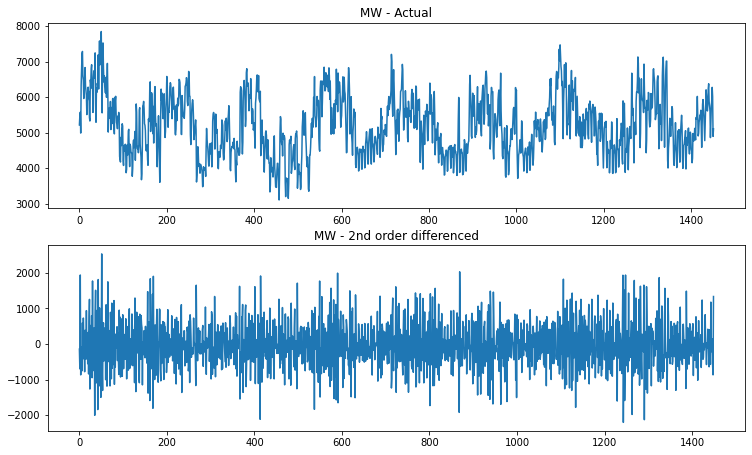

In [158]:
fig, ax = plt.subplots(2,1, figsize=(12.5,7.5))

df_train.reset_index()['y'].plot(ax=ax[0])
df_differenced.reset_index()['y'].plot(ax=ax[1])
ax[0].set_title('MW - Actual')
ax[1].set_title('MW - 2nd order differenced')

In [162]:
# ADF Test on each column
for name, column in df_differenced.iteritems():
    adf(column, variable=column.name)
    print('\n')

 Augmented Dickey-Fuller Test on  TEMPERATURE_mean
 Null Hypothesis: Variable is Non-Stationary.
 Significance Level         =  0.05
 Test Statistic             =  -15.7412
 No. Lags Chosen (lowest AIC)=  24
 Critical value 1% -3.435
 Critical value 5% -2.864
 Critical value 10% -2.568
p-Value =  0.0 . P value is less than critical value. Reject Null H. Series is Stationary.


 Augmented Dickey-Fuller Test on  TEMPERATURE_min
 Null Hypothesis: Variable is Non-Stationary.
 Significance Level         =  0.05
 Test Statistic             =  -16.345
 No. Lags Chosen (lowest AIC)=  24
 Critical value 1% -3.435
 Critical value 5% -2.864
 Critical value 10% -2.568
p-Value =  0.0 . P value is less than critical value. Reject Null H. Series is Stationary.


 Augmented Dickey-Fuller Test on  TEMPERATURE_max
 Null Hypothesis: Variable is Non-Stationary.
 Significance Level         =  0.05
 Test Statistic             =  -15.8913
 No. Lags Chosen (lowest AIC)=  24
 Critical value 1% -3.435
 Critical

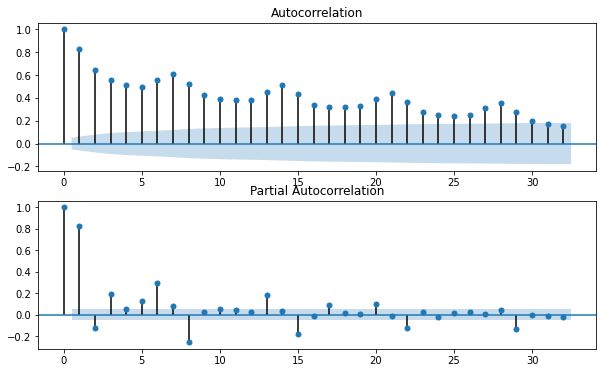

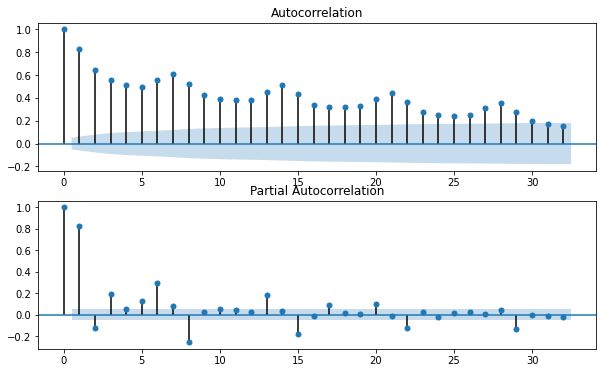

In [163]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2,1, figsize=(10,6))
plot_acf(tsdf['y'], ax=ax[0])
plot_pacf(tsdf['y'], ax=ax[1])

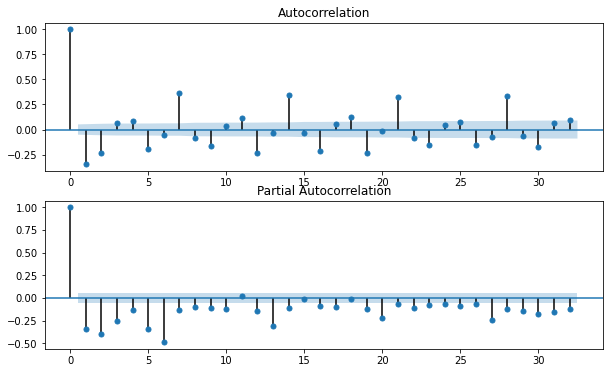

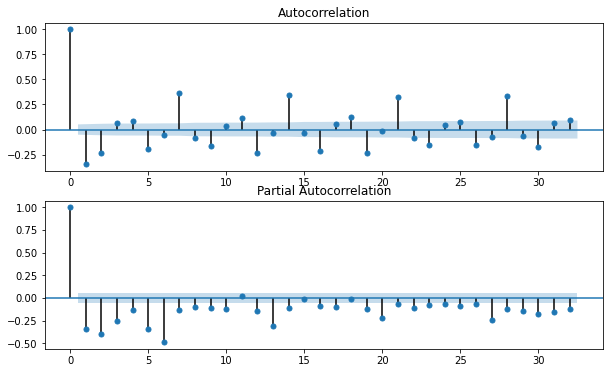

In [164]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2,1, figsize=(10,6))
plot_acf(df_differenced['y'], ax=ax[0])
plot_pacf(df_differenced['y'], ax=ax[1])

In [167]:
# call the model and insert the differenced data
model = VAR(df_differenced)
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,47.69,47.73,5.159e+20,47.71
1,43.10,43.58,5.219e+18,43.28
2,40.80,41.73,5.237e+17,41.15
3,39.57,40.95,1.538e+17,40.09
4,38.55,40.36,5.522e+16,39.23
5,37.80,40.06,2.607e+16,38.64
6,-23.18,-20.48,8.538e-11,-22.18
7,-26.49,-23.35*,3.131e-12,-25.32
8,-26.58,-22.99,2.870e-12,-25.24
9,-27.36,-23.33,1.308e-12,-25.86


In [261]:
## SET LAG

model_fitted = model.fit(7)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 31, Aug, 2021
Time:                     17:50:51
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                   -23.0733
Nobs:                     1443.00    HQIC:                  -25.0389
Log likelihood:          -2754.68    FPE:                4.14838e-12
AIC:                     -26.2095    Det(Omega_mle):     2.32481e-12
--------------------------------------------------------------------
Results for equation TEMPERATURE_mean
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                             0.004739         0.141937            0.033           0.973
L1.TEMPERATURE_mean              -0.682549         0.079745           -8.559           0.000
L

In [262]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(tsdf.columns, out):
    print(col, ':', round(val, 2))

TEMPERATURE_mean : 2.05
TEMPERATURE_min : 2.04
TEMPERATURE_max : 2.08
RELATIVE_HUMIDITY_mean : 2.07
WIND_GUST_MPH_mean : 2.05
CLOUD_COVER_mean : 2.08
PRECIPITATION_mean : 2.09
weekday : 1.93
month : 2.03
holiday : 2.08
y : 2.04


In [263]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order) 

# Separate input data for forecasting
# the goal is to forecast based on the last 4 inputs (since the lag is 4)
forecast_input = df_differenced.values[-lag_order:]

7


In [264]:
# Forecast
## we insert the last four values and inform the model to predict the next 10 values

fc = model_fitted.forecast(y=forecast_input, steps=nobs)

## organize the output into a clear DataFrame layout, add '_f' suffix at each column indicating they are the forecasted values
df_forecast = pd.DataFrame(fc, index=tsdf.index[-nobs:], columns=tsdf.columns + '_f')
df_forecast

,TEMPERATURE_mean_f,TEMPERATURE_min_f,TEMPERATURE_max_f,RELATIVE_HUMIDITY_mean_f,WIND_GUST_MPH_mean_f,CLOUD_COVER_mean_f,PRECIPITATION_mean_f,weekday_f,month_f,holiday_f,y_f
ds,,,,,,,,,,,
2018-12-23,7.222080,1.596803,-5.459700,12.954821,-8.472531,-32.880807,55.437812,2.348740e-15,-0.176236,-0.026226,-92.440166
2018-12-24,9.741035,6.265092,17.850980,1.983066,4.344078,17.360233,-17.915794,-7.000000e+00,0.013506,0.185533,504.846181
2018-12-25,4.911853,10.435862,0.511132,5.352067,-8.919030,10.116214,13.063611,7.000000e+00,0.260553,-0.289409,-660.105136
2018-12-26,-3.714613,-6.478002,-0.978980,-6.357836,9.570081,1.976488,-1.496161,-3.291724e-14,-0.080746,0.155372,-20.391199
2018-12-27,-2.960215,-0.994127,-6.112990,5.306409,-0.239232,13.841388,3.931027,9.753396e-15,0.281524,-0.056367,48.045034
2018-12-28,2.627016,1.896530,1.099034,-7.542064,1.640930,-8.550119,-12.078698,7.477878e-14,-0.460561,0.069530,-213.129479
2018-12-29,-1.438241,-2.808942,2.445322,-4.594947,-2.059138,-30.590628,-5.384014,3.212127e-14,-0.052861,-0.038899,-242.305189
2018-12-30,-2.060453,0.609752,-2.460418,12.346616,-3.080426,39.404079,13.275110,-2.519476e-15,0.151557,0.007257,528.926977
2018-12-31,1.475561,-0.512487,-0.050862,-2.226700,1.734603,-21.582333,1.868785,-7.000000e+00,0.055083,0.079109,487.618461


In [265]:
# get a copy of the forecast
df_fc = df_forecast.copy()

# get column name from the original dataframe
columns = df_train.columns

# Roll back from the 1st order differencing
# we take the cumulative sum (from the top row to the bottom) for each of the forecasting data, 
## and the add to the previous step's original value (since we deduct each row from the previous one)
## we rename the new forecasted column with the prefix 'forecast'

for col in columns: 
     df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_f'].cumsum()

## if you perform second order diff, make sure to get the difference from the last row and second last row of df_train
for col in columns:
    df_fc[str(col)+'_first_differenced'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_f'].cumsum()
    df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_first_differenced'].cumsum()
df_results = df_fc
df_results.head()

,TEMPERATURE_mean_f,TEMPERATURE_min_f,TEMPERATURE_max_f,RELATIVE_HUMIDITY_mean_f,WIND_GUST_MPH_mean_f,CLOUD_COVER_mean_f,PRECIPITATION_mean_f,weekday_f,month_f,holiday_f,y_f,TEMPERATURE_mean_forecast,TEMPERATURE_min_forecast,TEMPERATURE_max_forecast,RELATIVE_HUMIDITY_mean_forecast,WIND_GUST_MPH_mean_forecast,CLOUD_COVER_mean_forecast,PRECIPITATION_mean_forecast,weekday_forecast,month_forecast,holiday_forecast,y_forecast,TEMPERATURE_mean_first_differenced,TEMPERATURE_min_first_differenced,TEMPERATURE_max_first_differenced,RELATIVE_HUMIDITY_mean_first_differenced,WIND_GUST_MPH_mean_first_differenced,CLOUD_COVER_mean_first_differenced,PRECIPITATION_mean_first_differenced,weekday_first_differenced,month_first_differenced,holiday_first_differenced,y_first_differenced
ds,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-12-23,7.222080,1.596803,-5.459700,12.954821,-8.472531,-32.880807,55.437812,2.348740e-15,-0.176236,-0.026226,-92.440166,31.152636,19.596803,44.540300,69.515007,21.726543,69.572896,20.604478,6.000000e+00,11.823764,-0.026226,5223.961834,-9.828846,-10.403197,-13.459700,-2.332216,-2.125309,-26.353029,9.604478,1.0,-0.176236,-0.026226,119.333834
2018-12-24,9.741035,6.265092,17.850980,1.983066,4.344078,17.360233,-17.915794,-7.000000e+00,0.013506,0.185533,504.846181,31.064825,15.458697,48.931579,69.165856,23.945312,60.580100,12.293163,5.329071e-15,11.661034,0.133081,5848.141850,-0.087811,-4.138105,4.391279,-0.349150,2.218769,-8.992797,-8.311315,-6.0,-0.162730,0.159307,624.180015
2018-12-25,4.911853,10.435862,0.511132,5.352067,-8.919030,10.116214,13.063611,7.000000e+00,0.260553,-0.289409,-660.105136,35.888868,21.756454,53.833990,74.168774,17.245050,61.703517,17.045459,1.000000e+00,11.758858,0.002979,5812.216729,4.824043,6.297757,4.902411,5.002917,-6.700261,1.123417,4.752296,1.0,0.097823,-0.130102,-35.925121
2018-12-26,-3.714613,-6.478002,-0.978980,-6.357836,9.570081,1.976488,-1.496161,-3.291724e-14,-0.080746,0.155372,-20.391199,36.998298,21.576209,57.757421,72.813855,20.114870,64.803422,20.301594,2.000000e+00,11.775935,0.028248,5755.900410,1.109430,-0.180245,3.923432,-1.354919,2.869820,3.099905,3.256135,1.0,0.017077,0.025269,-56.316319
2018-12-27,-2.960215,-0.994127,-6.112990,5.306409,-0.239232,13.841388,3.931027,9.753396e-15,0.281524,-0.056367,48.045034,35.147513,20.401836,55.567862,76.765345,22.745459,81.744716,27.488755,3.000000e+00,12.074536,-0.002849,5747.629124,-1.850785,-1.174373,-2.189559,3.951490,2.630588,16.941294,7.187162,1.0,0.298602,-0.031097,-8.271285


In [266]:
forecast = df_results['y_forecast'].values
actual = df_test['y']

mae = np.mean(np.abs(forecast - actual))    # MAE
rmse = np.mean((forecast - actual)**2)**.5  # RMSE
mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
print('Mean Absolute Error           : ', mae) 
print('Root Mean Squared Error       : ',rmse)
print('Mean Absolute Percentage Error: ',mape)

Mean Absolute Error           :  540.9743736961414
Root Mean Squared Error       :  648.9694327723262
Mean Absolute Percentage Error:  0.11084162803184976


In [267]:
df_results.loc[:, [ 'y_forecast']]

,y_forecast
ds,
2018-12-23,5223.961834
2018-12-24,5848.141850
2018-12-25,5812.216729
2018-12-26,5755.900410
2018-12-27,5747.629124
2018-12-28,5526.228361
2018-12-29,5062.522408
2018-12-30,5127.743432
2018-12-31,5680.582917


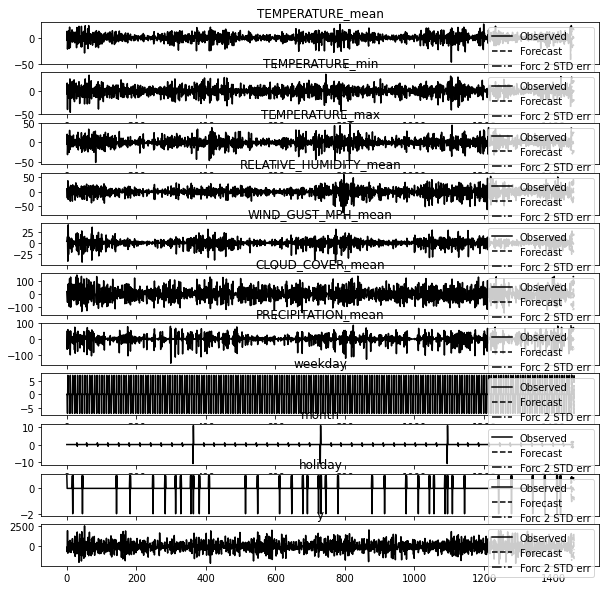

In [268]:
## you can use the statsmodels plot_forecast method but the output is not clean
fig = model_fitted.plot_forecast(10)

In [269]:
forecast = df_results['y_forecast']
actual = df_test['y']

forecast.to_frame().join(actual)

,y_forecast,y
ds,,
2018-12-23,5223.961834,4875.800
2018-12-24,5848.141850,4937.264
2018-12-25,5812.216729,4704.005
2018-12-26,5755.900410,5443.333
2018-12-27,5747.629124,5473.208
2018-12-28,5526.228361,5085.966
2018-12-29,5062.522408,4864.620
2018-12-30,5127.743432,4948.338
2018-12-31,5680.582917,5217.259


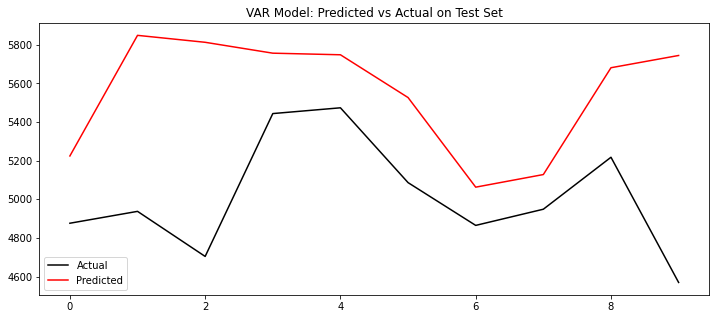

In [270]:
fig, ax = plt.subplots(figsize=(12, 5))

df_test.reset_index()['y'].plot(color='k', label='Actual')
df_results.reset_index()['y_forecast'].plot(color='r', label='Predicted')

plt.title('VAR Model: Predicted vs Actual on Test Set')
ax.legend()